# DATA 512, A1: Data curation

**TODO** add in something that talks about the prereqs and what it requires to run this code (this is the first part of automating (the second is code that generates the results)

Top level: acquisition, processing, analysis

In [629]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText # for addtl annotations in charts
from IPython.core.pylabtools import figsize
import seaborn as sns
%matplotlib inline 

import requests
import os
import json

In [633]:
sns.set_style("whitegrid")
figsize(14,7)

## Page counts
- 1/1/2008 to 7/31/2016 per the assignment wiki page (although 8/1/2008 to 7/31/2016 per class slides)
- 'desktop-site' can also be 'mobile-site'

URL 
https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2008010100/2008040100

API docs w/ URL
https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end

## Page views
- 7/1/2015 to present per class slides
- 'desktop' can also be 'mobile-app' or 'mobile-web'
- 'user' says we do not want spider/crawler views

URL https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2017100100

API docs w/ URL https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end

**TODO** make sure to explain why we're setting the API params as we do in the hardcode URL and changeable stuff below, since we refer to here.

**TODO** note that real reproducibility needs tests for the code - i'd normally put the functions i define below in a separate file that I import here, and then test them from that separate file. for this one i'll just keep everything in this file for simplicity even though it means i can't test them the way i normally would.

In [91]:
PAGECOUNTS_START = '2008010100'
PAGECOUNTS_END = '2016073100'
PAGEVIEWS_START = '2015070100'
PAGEVIEWS_END = '2017093000'

API_DATE_FORMAT = '%Y%m%d%H'

# note that passing the exact ending day of the last month, as above, causes the API to return 
# the same same result as passing a day in the following month; passing the ending day
# also simplifies the filename generation code because it doesn't need to 'go back'

USER_AGENT = 'https://github.com/aenfield'

In [92]:
def get_param_dict_from_params(access, start, end):
    """Convenience function to get a params dict given the passed values."""
    return {'access': access, 'start': start, 'end': end}

In [130]:
def get_filename_from_params(apiname, params):
    """TODO docs. include that because of the practice of passing a """
    
    # Mark up the dict so we can pass a dict with all values we need.
    # We have to format the start/end because .format doesn't handle
    # string slicing in the format string itself. We'll use a copy
    # so we don't modify the passed dict as an undesirable side effect.
    p = params.copy()
    p['apiname'] = apiname 
    p['start'] = p['start'][:6] # we only want year/month - could convert to datetime and format but this is simpler given that we know the input format
    p['end'] = p['end'][:6]
    return "{apiname}_{access}_{start}_{end}.json".format(**p)

In [324]:
def download_page_access_data(apiname, params, user_agent, force=False, verbose=False):
    """TODO add docs, including the allowed values for access per a given endpoint, 
    and that behavior is to just pass through failure if something incorrect is passed, and that
    this saves the data as files if they don't already exist/haven't been downloaded yet"""
    # TODO incorp these notes into the genearl or param docs
    # Define endpoint URLs to include/hardcode the params we don't need to vary, per the above text. 
    # Also, for ease in calling the function, I'm b clarity and since only access/access-site needs to change per request, I've promoted 
    # this to a specifically  named function parameter, which I'll consistently call 'access'. Finally, 
    # since the API doc says only 'User-Agent' is required (not 'From'), I'll also promote this to 
    # a function parameter. we need to pass more than we would as params so we have the data easily 
    # to use when checking for/writing files
    
    filename = get_filename_from_params(apiname, params)
    if verbose: print("Using filename: {}.".format(filename)) 
    
    if (not os.path.exists(filename)) | (force == True):
        if (apiname == 'pagecounts'):
            endpoint_template = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/{access}/monthly/{start}/{end}'
        elif (apiname == 'pageviews'):
            endpoint_template = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/{access}/user/monthly/{start}/{end}'
        # note that I'm not checking for valid apiname values - per what I understand
        # standard Python practice to be, it's the caller's responsibility to pass
        # correct values - here if they don't, the REST request will fail

        url = endpoint_template.format(**params)
        if verbose: print("Retrieving {} .".format(url))
            
        response = requests.get(url, headers = {'User-Agent':'{}'.format(user_agent)})
        if verbose: print("Done with retrieval. Status code: {}.".format(response.status_code))
            
        with open(filename, 'w') as file:
            file.write(response.text) # requests doesn't have a method to download and write at the same time, like urllib, so we write here (urllib doesn't easily enable user agent setting, so we don't use it)
        if verbose: print("Saved file.")
    else:
        if verbose: print("Local file exists already.")

In [325]:
data_specs = [('pagecounts', 'desktop-site', PAGECOUNTS_START, PAGECOUNTS_END),
              ('pagecounts', 'mobile-site', PAGECOUNTS_START, PAGECOUNTS_END),
              ('pageviews', 'desktop', PAGEVIEWS_START, PAGEVIEWS_END),
              ('pageviews', 'mobile-web', PAGEVIEWS_START, PAGEVIEWS_END),
              ('pageviews', 'mobile-app', PAGEVIEWS_START, PAGEVIEWS_END)]

In [327]:
for (apiname, access, start, end) in data_specs:
    download_page_access_data(apiname, get_param_dict_from_params(access, start, end), 
                         USER_AGENT, force=False, verbose=True)

Using filename: pagecounts_desktop-site_200801_201607.json.
Local file exists already.
Using filename: pagecounts_mobile-site_200801_201607.json.
Local file exists already.
Using filename: pageviews_desktop_201507_201709.json.
Local file exists already.
Using filename: pageviews_mobile-web_201507_201709.json.
Local file exists already.
Using filename: pageviews_mobile-app_201507_201709.json.
Local file exists already.


In [304]:
def get_cleaned_dataframe(apiname, access, start, end):
    """TODO doc"""
    # TODO this is messy - is there a better way?
    filename = get_filename_from_params(apiname, get_param_dict_from_params(access, start, end))
    with open(filename) as json_data:
        d_as_json = json.load(json_data)

    # pandas read_json needs the data as a string (not parsed JSON) and without the 
    # 'items' preface that the API returns; we can't let read_json convert dates because it 
    # doesn't handle this format ok - we'll convert next
    df = pd.read_json(json.dumps(d_as_json['items']), orient='records', convert_dates=False)
    
    # add column that specifies the api from which this dataframe came
    df['api'] = apiname
    
    # rename doesn't error if the column doesn't exist, so no need to special case dataframes from diff APIs
    df.rename(columns = {'access-site': 'access', 'count': 'views'}, inplace=True)
    
    # ignore so we don't fail on dfs that don't have all columns
    df.drop(['agent', 'project', 'granularity'], axis=1, errors='ignore', inplace=True) 
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=API_DATE_FORMAT)
    
    df.set_index('timestamp', inplace=True)

    return df

In [342]:
all_data_as_dfs = {f'{apiname}_{access}' : get_cleaned_dataframe(apiname, access, start, end) for 
                   (apiname, access, start, end) in data_specs}
len(all_data_as_dfs)

5

In [343]:
pageviews_mobile_df = (all_data_as_dfs['pageviews_mobile-web']['views'] + all_data_as_dfs['pageviews_mobile-app']['views']).to_frame()
pageviews_mobile_df['access'] = 'mobile'
pageviews_mobile_df['api'] = 'pageviews'
pageviews_mobile_df[:3]

,views,access,api
timestamp,,,
2015-07-01,3288755294,mobile,pageviews
2015-08-01,3302333038,mobile,pageviews
2015-09-01,3170203333,mobile,pageviews


In [616]:
all_data_long = pd.concat([all_data_as_dfs['pagecounts_desktop-site'], all_data_as_dfs['pagecounts_mobile-site'],
                           all_data_as_dfs['pageviews_desktop'], pageviews_mobile_df])
len(all_data_long)

179

In [617]:
all_data_long['api'].value_counts(dropna=False)

pagecounts    125
pageviews      54
Name: api, dtype: int64

In [618]:
all_data_long['access'].value_counts(dropna=False)

desktop-site    103
mobile           27
desktop          27
mobile-site      22
Name: access, dtype: int64

In [619]:
all_data_long[:3]

,access,api,views
timestamp,,,
2008-01-01,desktop-site,pagecounts,4930902570
2008-02-01,desktop-site,pagecounts,4818393763
2008-03-01,desktop-site,pagecounts,4955405809


In [620]:
all_data_wide = all_data_long.pivot(columns='access', values='views')
all_data_wide[:3]

access,desktop,desktop-site,mobile,mobile-site
timestamp,,,,
2008-01-01,NaN,4.930903e+09,NaN,NaN
2008-02-01,NaN,4.818394e+09,NaN,NaN
2008-03-01,NaN,4.955406e+09,NaN,NaN


In [621]:
all_data_wide.rename(columns = {'desktop':'pageview_desktop_views',
                                'mobile':'pageview_mobile_views',
                                'desktop-site':'pagecount_desktop_views',
                                'mobile-site':'pagecount_mobile_views'}, inplace=True)

all_data_wide.columns.name = '' # don't want the default column index name of 'access' anymore

all_data_wide[:3]

,pageview_desktop_views,pagecount_desktop_views,pageview_mobile_views,pagecount_mobile_views
timestamp,,,,
2008-01-01,NaN,4.930903e+09,NaN,NaN
2008-02-01,NaN,4.818394e+09,NaN,NaN
2008-03-01,NaN,4.955406e+09,NaN,NaN


In [622]:
all_data_wide['pagecount_all_views'] = all_data_wide['pagecount_desktop_views'].fillna(0) + all_data_wide['pagecount_mobile_views'].fillna(0)
all_data_wide['pageview_all_views'] = all_data_wide['pageview_desktop_views'].fillna(0) + all_data_wide['pageview_mobile_views'].fillna(0)
all_data_wide[:3]

,pageview_desktop_views,pagecount_desktop_views,pageview_mobile_views,pagecount_mobile_views,pagecount_all_views,pageview_all_views
timestamp,,,,,,
2008-01-01,NaN,4.930903e+09,NaN,NaN,4.930903e+09,0.0
2008-02-01,NaN,4.818394e+09,NaN,NaN,4.818394e+09,0.0
2008-03-01,NaN,4.955406e+09,NaN,NaN,4.955406e+09,0.0


In [623]:
all_data_wide = all_data_wide.reindex_axis(sorted(all_data_wide.columns), axis=1)

In [624]:
all_data_wide.loc[all_data_wide.index > pd.to_datetime(PAGECOUNTS_END, format='%Y%m%d%H'), 'pagecount_all_views'] = np.nan
all_data_wide.loc[all_data_wide.index < pd.to_datetime(PAGEVIEWS_START, format='%Y%m%d%H'), 'pageview_all_views'] = np.nan

In [625]:
all_data_wide

,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
timestamp,,,,,,
2008-01-01,4.930903e+09,4.930903e+09,NaN,NaN,NaN,NaN
2008-02-01,4.818394e+09,4.818394e+09,NaN,NaN,NaN,NaN
2008-03-01,4.955406e+09,4.955406e+09,NaN,NaN,NaN,NaN
2008-04-01,5.159162e+09,5.159162e+09,NaN,NaN,NaN,NaN
2008-05-01,5.584691e+09,5.584691e+09,NaN,NaN,NaN,NaN
2008-06-01,5.712104e+09,5.712104e+09,NaN,NaN,NaN,NaN
2008-07-01,5.306303e+09,5.306303e+09,NaN,NaN,NaN,NaN
2008-08-01,5.140156e+09,5.140156e+09,NaN,NaN,NaN,NaN
2008-09-01,5.479534e+09,5.479534e+09,NaN,NaN,NaN,NaN


In [630]:
def add_text(ax, text, loc=5):
    """TODO doc."""
    fp = dict(size=12)
    _at = AnchoredText(text, loc=3, prop=fp)
    ax.add_artist(_at)
    return _at

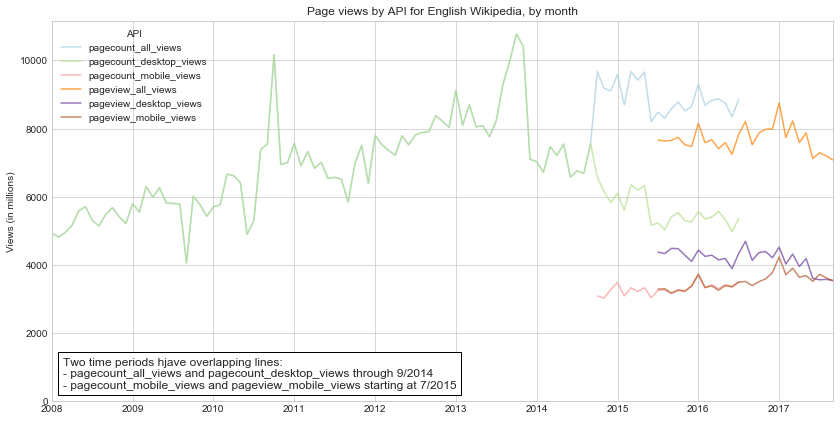

In [635]:
ax = all_data_wide.plot(title='Page views by API for English Wikipedia, by month', 
                        ylim=0, sort_columns=True, alpha=0.7, cmap='Paired') # Paired cmap does a bit better job of showing overlapping lines ok
#ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: '{:5.3}'.format(x)))
#ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: human_format(x, precision=0)))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f'{x / 1000000.0:.0f}'))
plt.ylabel('Views (in millions)')
plt.xlabel('') # don't need name of index, which is 'timestamp'
ax.legend(title='API')
add_text(ax, "Two time periods hjave overlapping lines:\n- pagecount_all_views and pagecount_desktop_views through 9/2014\n- pagecount_mobile_views and pageview_mobile_views starting at 7/2015")

plt.savefig('page_views_by_api.png', dpi=300)

In [606]:
# we need to specify the index so that values are appropriately associated with the 
# index values that already exist in the data frame - without this, the Series that is
# returned from the right side has the default integer index values, and since these
# don't match the index values in the dataframe, the assignment would just result in 
# all np.nan values for the new year and month columns
all_data_wide['year'] = pd.Series(all_data_wide.index.map(lambda dt: pd.Timestamp(dt).year), index=all_data_wide.index)
all_data_wide['month'] = pd.Series(all_data_wide.index.map(lambda dt: f"{pd.Timestamp(dt).month:02}"), index=all_data_wide.index) # format to pad with leading zero

In [611]:
# dates are the first date of the old API to the last date of the new API
filename_output = f'en-wikipedia_traffic_{PAGECOUNTS_START[:6]}-{PAGEVIEWS_END[:6]}.csv'
filename_output

'en-wikipedia_traffic_200801-201709.csv'

In [614]:
all_data_wide.fillna(0).to_csv(filename_output, index=False)